# Document Clustering and Topic Modeling

In this project, we will analyze the underlying structure of documents automatically and visualize the clustering result using natural language processing models/tools.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [141]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [142]:
#import three lists: titles and wikipedia synopses
titles = open('../data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('../data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('../data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [38]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:20])

We use 179 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    #separate by sentence first.
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [39]:
# take an example to try
tokenization_and_stemming("DePaul University is an famous university in the world.")

['depaul', 'univers', 'famous', 'univers', 'world']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [7]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [54]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print (vocab_frame_dict['on'])

on


# Part 3: TF-IDF（Term Frequency-Inverse Document Frequency）

In [55]:
#define vectorizer parameters
#max_df, max document frequency
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 538 terms.


In [64]:
tfidf_matrix.todense()###words importance

matrix([[0.01548417, 0.        , 0.        , ..., 0.08116415, 0.05900743,
         0.0406339 ],
        [0.05836682, 0.        , 0.0244088 , ..., 0.05948916, 0.        ,
         0.00957297],
        [0.        , 0.        , 0.01960667, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.01356779, 0.        , 0.        , ..., 0.        , 0.        ,
         0.01780244],
        [0.01434229, 0.0296827 , 0.03598737, ..., 0.00835319, 0.02732796,
         0.01881867],
        [0.20623577, 0.        , 0.        , ..., 0.06005757, 0.        ,
         0.06765104]])

In [10]:
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [11]:
tf_selected_words = tfidf_model.get_feature_names()

# Calculate Document Similarity

Using cosine value to get vector angle, that could represent similarity.

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print (cos_matrix)

[[1.         0.1996283  0.23342595 ... 0.3581728  0.3277855  0.17714484]
 [0.1996283  1.         0.26626879 ... 0.26910321 0.22856581 0.10870124]
 [0.23342595 0.26626879 1.         ... 0.27738654 0.24669308 0.12805055]
 ...
 [0.3581728  0.26910321 0.27738654 ... 1.         0.55040973 0.08151334]
 [0.3277855  0.22856581 0.24669308 ... 0.55040973 1.         0.13005234]
 [0.17714484 0.10870124 0.12805055 ... 0.08151334 0.13005234 1.        ]]


# Part 4: K-means clustering

In [67]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
print(len(clusters))

100


## 4.1. Analyze K-means Result

In [14]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [15]:
frame.head(10)

,rank,title,cluster
4,0,The Godfather,4
2,1,The Shawshank Redemption,2
4,2,Schindler's List,4
4,3,Raging Bull,4
3,4,Casablanca,3
2,5,One Flew Over the Cuckoo's Nest,2
1,6,Gone with the Wind,1
4,7,Citizen Kane,4
2,8,The Wizard of Oz,2
1,9,Titanic,1


In [16]:
print ("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
2,36
4,28
3,17
1,16
0,3


In [17]:
grouped = frame['rank'].groupby(frame['cluster'])
print ("Average rank (1 to 100) per cluster:")
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,51.333333
1,47.187500
2,56.972222
3,36.529412
4,48.892857


In [18]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ",", end='')
    print ()
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ") 
    print (", ".join(cluster_movies))
    print()

<Document clustering result by K-means>
Cluster 0 words:musical,performed,filmed,singing,dance,join,
Cluster 0 titles (3 movies): 
Singin' in the Rain, Amadeus, Yankee Doodle Dandy

Cluster 1 words:george,marries,home,love,war,woman,
Cluster 1 titles (16 movies): 
Gone with the Wind, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, It's a Wonderful Life, Gandhi, The Philadelphia Story, An American in Paris, The Best Years of Our Lives, City Lights, The King's Speech, A Place in the Sun, Out of Africa, Tootsie, Network, Wuthering Heights

Cluster 2 words:car,police,killing,mr.,n't,drives,
Cluster 2 titles (36 movies): 
The Shawshank Redemption, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Psycho, Sunset Blvd., Vertigo, West Side Story, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Some Like It Hot, 12 Angry Men, Unforgiven, Rocky, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, The Deer Hunter, The French Connection, It Happened One Night, Goo

## 4.2. Plot K-means Result

In [19]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

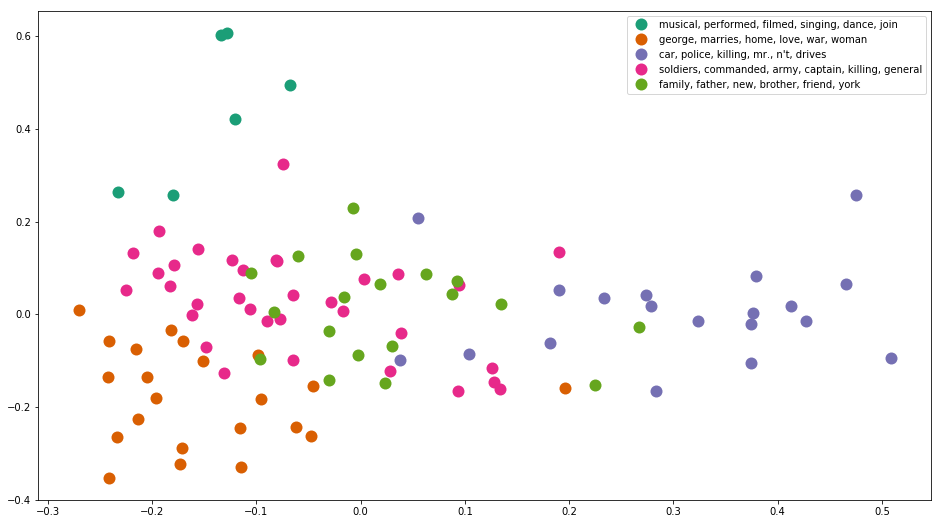

In [93]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=1)  #show legend with only 1 point, position is right top.

plt.show() #show the plot

In [21]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

5.1 sklearn LDA, LDA requires interger, it cannot process float numbers.

In [152]:
from sklearn.decomposition import LatentDirichletAllocation
lda_sk = LatentDirichletAllocation(n_components = 5, learning_method = 'online')

In [153]:
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [154]:
lda_sk.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [155]:
topic_word = lda_sk.components_
topic_word

array([[12.38477202,  1.10089332, 27.2685827 , ..., 19.61506684,
         8.60340569, 14.88848291],
       [34.5401686 ,  8.17805471, 11.37093489, ..., 57.61246405,
        37.47655859, 62.75967948],
       [13.28088199, 23.56108791,  9.09423878, ..., 61.00211221,
        85.76310802, 33.41504979],
       [ 8.10730487, 45.48095633, 21.05959158, ..., 35.95131471,
        17.83143959, 38.00138196],
       [ 4.99527328, 17.48693584, 16.54407945, ..., 34.90883997,
        80.3303978 , 35.91251716]])

In [156]:
np.array(tf_selected_words)[np.argsort(topic_word[0])]

array(['abandon', 'involv', 'cross', 'jame', 'apart', 'suspect', 'posit',
       'shout', 'intent', 'remind', 'slip', 'secret', 'met', 'drunk',
       'child', 'attract', 'action', 'took', 'someth', 'troubl',
       'prevent', 'news', 'desper', 'known', 'street', 've', 'everi',
       'step', 'boy', 'wo', 'meanwhil', 'quiet', 'fli', 'heart', 'ago',
       'declar', 'investig', 'assign', 'tear', 'reason', 'desert', 'hour',
       'pack', 'confront', 'moment', 'mind', 'anyth', 'angri', 'accid',
       'wish', 'earli', 'appar', 'present', 'ii', 'cri', 'cold', 'suffer',
       'consid', 'unabl', 'reluct', 'wrong', 'concern', 'polic', 'figur',
       'ring', 'parent', 'grab', 'struggl', 'movi', 'phone', 'understand',
       'join', 'high', 'someon', 'remov', 'sister', 'condit', 'attent',
       'crime', 'compani', 'evid', 'heard', 'dark', 'spend', 'strike',
       'push', 'field', 'wear', 'insid', 'shock', 'collaps', 'accept',
       'observ', 'seen', 'blow', 'notic', 'land', 'soldier', 're

In [157]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #np.argsort()->sort by axis, and return index
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1]
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [158]:
topic_keywords_list

[['mr.', 'singing', 'prison', 'town', 'captain', 'children'],
 ['water', 'mother', 'sister', 'father', 'love', 'house'],
 ['george', 'car', 'police', 'apartment', 'john', 'family'],
 ['army', 'soldiers', 'war', 'killing', 'general', 'commanded'],
 ['father', 'new', 'fight', 'york', 'job', 'rings']]

In [159]:
doc_topic = lda_sk.transform(tfidf_matrix_lda)
doc_topic.shape

(100, 5)

In [160]:
topic_doc_dict = {}
print("<Document clustering result by LDA_sklearn>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax() #argmax()return index
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + "titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print(', '.join(topic_doc_dict[i]))
    print()

<Document clustering result by LDA_sklearn>
Cluster 2 words: george, car, police, apartment, john, family
Cluster 2titles (32 movies): 
The Godfather, Citizen Kane, The Godfather: Part II, Psycho, Sunset Blvd., On the Waterfront, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, It's a Wonderful Life, Amadeus, An American in Paris, The Apartment, Goodfellas, The French Connection, The King's Speech, A Place in the Sun, Rain Man, Tootsie, Fargo, The Green Mile, Close Encounters of the Third Kind, The Graduate, American Graffiti, Pulp Fiction, The Maltese Falcon, Taxi Driver, Wuthering Heights, Rebel Without a Cause, Rear Window, The Third Man, North by Northwest

Cluster 0 words: mr., singing, prison, town, captain, children
Cluster 0titles (17 movies): 
The Shawshank Redemption, Schindler's List, Raging Bull, One Flew Over the Cuckoo's Nest, The Sound of Music, 2001: A Space Odyssey, Singin' in the Rain, Unforgiven, To Kill a Mockingbird, My Fair Lady, High Noon, Out of Africa

5.2 Another LDA

In [22]:
#Now we use synopses to build a 100*538 matrix (terms)
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [163]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=1)

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [165]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -484683
INFO:lda:<10> log likelihood: -428330
INFO:lda:<20> log likelihood: -412489
INFO:lda:<30> log likelihood: -406790
INFO:lda:<40> log likelihood: -403019
INFO:lda:<50> log likelihood: -400070
INFO:lda:<60> log likelihood: -398296
INFO:lda:<70> log likelihood: -397266
INFO:lda:<80> log likelihood: -395732
INFO:lda:<90> log likelihood: -395476
INFO:lda:<100> log likelihood: -394666
INFO:lda:<110> log likelihood: -394617
INFO:lda:<120> log likelihood: -393980
INFO:lda:<130> log likelihood: -393121
INFO:lda:<140> log likelihood: -392773
INFO:lda:<150> log likelihood: -392559
INFO:lda:<160> log likelihood: -392274
INFO:lda:<170> log likelihood: -391875
INFO:lda:<180> log likelihood: -392254
INFO:lda:<190> log likelihood: -391966
INFO:lda:<200> log likelihood: -391777
INFO:lda:<210> log likelihood: -391467
INFO:lda:<220> log likelihood: -3910

In [166]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print (', '.join(topic_doc_dict[i]))
    print ()

<Document clustering result by LDA>
Cluster 2 words: father, family, new, end, life, years
Cluster 2 titles (28 movies): 
The Godfather, Casablanca, Citizen Kane, The Godfather: Part II, Sunset Blvd., Forrest Gump, The Sound of Music, Singin' in the Rain, Amadeus, A Streetcar Named Desire, The Best Years of Our Lives, Doctor Zhivago, Braveheart, The Good, the Bad and the Ugly, Goodfellas, City Lights, The King's Speech, A Place in the Sun, Midnight Cowboy, Mr. Smith Goes to Washington, Rain Man, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, Network, Yankee Doodle Dandy

Cluster 4 words: killing, death, men, use, john, shooting
Cluster 4 titles (23 movies): 
The Shawshank Redemption, On the Waterfront, Star Wars, 2001: A Space Odyssey, Chinatown, The Bridge on the River Kwai, 12 Angry Men, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, To Kill a Mockingbird, Jaws, Butch Cassidy and the Sundance Kid, The Treasure of